# Exploratory Data Analysis

## Step 1: Data Load

In [95]:
import pandas as pd
import os

def reduce_twitter_dataset(input_file, output_file, sample_size=50000):
    """
    Reduces the Sentiment140 dataset while maintaining class balance.
    Columns: 0: target, 1: id, 2: date, 3: flag, 4: user, 5: text
    """

    if os.path.exists(output_file):
        print(f"Data already processed and saved at {output_file}")
        return

    cols = ["sentiment", "id", "date", "query", "user", "text"]

    print("Reading dataset in chunks...")
    # Using 'latin-1' encoding as this dataset often has special characters
    chunks = pd.read_csv(input_file, encoding='latin-1', header=None, names=cols, chunksize=100000)

    df_list = []
    for chunk in chunks:
        # Keep only necessary columns to save memory immediately
        df_list.append(chunk[['sentiment', 'text']])

    full_df = pd.concat(df_list)

    # Stratified sampling: Ensure 50/50 split of Positive (4) and Negative (0)
    # The dataset uses 0=negative, 2=neutral (rare), 4=positive
    negative_tweets = full_df[full_df['sentiment'] == 0].sample(n=sample_size//2, random_state=42)
    positive_tweets = full_df[full_df['sentiment'] == 4].sample(n=sample_size//2, random_state=42)

    reduced_df = pd.concat([negative_tweets, positive_tweets]).sample(frac=1).reset_index(drop=True)

    reduced_df.to_csv(output_file, index=False)
    print(f"Success! Reduced file saved to {output_file} with {len(reduced_df)} rows.")

In [96]:
init_data_path = f"{'\\'.join(os.getcwd().split('\\')[:-1])}/data/twitter_data.csv"
reduced_data_path = f"{'\\'.join(os.getcwd().split('\\')[:-1])}/data/reduced_twitter_data.csv"

In [97]:
reduce_twitter_dataset(init_data_path,reduced_data_path)

Data already processed and saved at c:\Users\water\OneDrive\GradSchool\DSE6212\Project/data/reduced_twitter_data.csv


In [98]:
df = pd.read_csv(reduced_data_path)
df.head()

,sentiment,text
0,0,"After readin hatz94's comment, i can't stop th..."
1,0,At Kincaid's alone because the rest of the @Ka...
2,0,hey @bradiewebbstack i miss you a lot man! nev...
3,4,Ladytsuki is waiting me to go to their house.....
4,0,hopes he can get to sleep at a decent time... ...


## Step 2: Preprocessing

In [99]:
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\water\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
def preprocess(text:str, stemmer:PorterStemmer|SnowballStemmer|None=None, lem:WordNetLemmatizer|None=None):
    assert not (stemmer is not None and lem is not None)

    # Lowercase
    text = text.lower()
    # Remove handles
    text = re.sub(r'\B@\S+','',text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in set(stopwords.words('english'))]

    # Stemming
    if stemmer:
        tokens = [stemmer.stem(token) for token in tokens]
    elif lem:
        tokens = [lem.lemmatize(token) for token in tokens]

    return " ".join(tokens)

In [101]:
df['text'] = df['text'].apply(preprocess)

In [102]:
df.head()

,sentiment,text
0,0,readin hatz94s comment cant stop thinkin bout ...
1,0,kincaids alone rest crew australia without ne
2,0,hey miss lot man never got say hey sway sway b...
3,4,ladytsuki waiting go house wahaha loves sooooo...
4,0,hopes get sleep decent time used able sleep we...


## Step 3: Analysis

Plot the frequency of the sentiment values.

array([[<Axes: title={'center': 'sentiment'}>]], dtype=object)

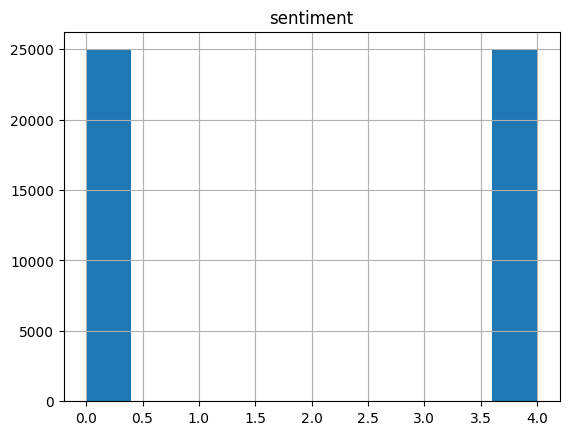

In [103]:
df.hist('sentiment')

In [104]:
def identify_most_frequent(tokens, num):
    """
    Input is the token list of the entire corpus
    """

    frequencies = {}
    for token in tokens:
        if token in frequencies:
            frequencies[token]+=1
        else:
            frequencies[token]=1

    most_common_counts = sorted(frequencies.values(), reverse=True)[0:num]
    common_tokens = []
    for tok, count in frequencies.items():
        if count in most_common_counts:
            common_tokens.extend([tok]*count)

    return common_tokens

In [106]:
import matplotlib.pyplot as plt

C:\Users\water\AppData\Local\Temp\ipykernel_37992\1468877632.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


[Text(0, 0, 'go'),
 Text(1, 0, 'day'),
 Text(2, 0, 'know'),
 Text(3, 0, 'see'),
 Text(4, 0, 'one'),
 Text(5, 0, 'time'),
 Text(6, 0, 'good'),
 Text(7, 0, 'dont'),
 Text(8, 0, 'amp'),
 Text(9, 0, 'get'),
 Text(10, 0, 'great'),
 Text(11, 0, 'im'),
 Text(12, 0, 'u'),
 Text(13, 0, 'love'),
 Text(14, 0, 'new'),
 Text(15, 0, 'got'),
 Text(16, 0, 'well'),
 Text(17, 0, 'lol'),
 Text(18, 0, 'back'),
 Text(19, 0, 'happy'),
 Text(20, 0, 'going'),
 Text(21, 0, 'today'),
 Text(22, 0, 'like'),
 Text(23, 0, 'thanks'),
 Text(24, 0, 'night')]

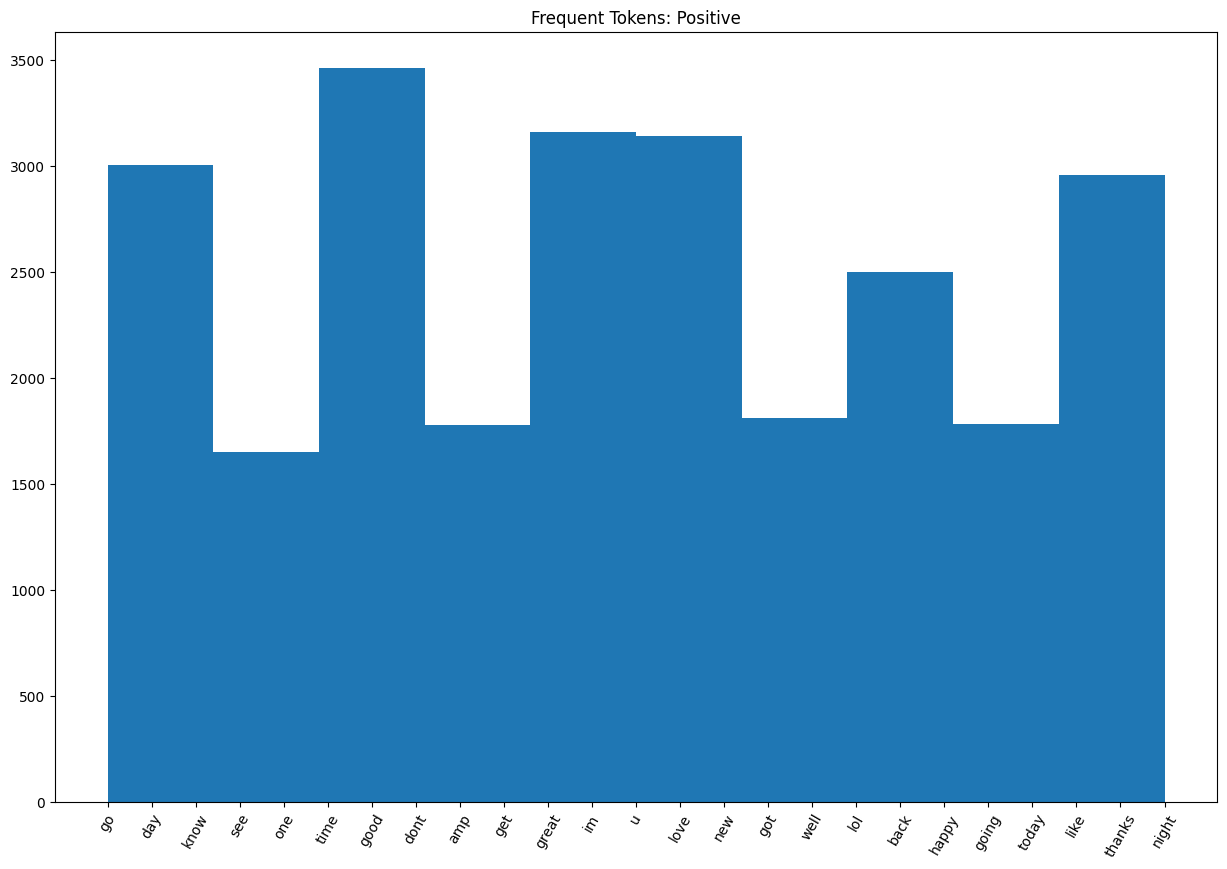

In [122]:
positive_tokens = word_tokenize(" ".join(df[df['sentiment']==4]["text"].values))
frequent_tokens_positive = identify_most_frequent(positive_tokens,25)

fig, ax = plt.subplots(nrows=1, figsize=(15,10))

ax.hist(frequent_tokens_positive)
ax.set_title("Frequent Tokens: Positive")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

C:\Users\water\AppData\Local\Temp\ipykernel_37992\2776032202.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


[Text(0, 0, 'cant'),
 Text(1, 0, 'got'),
 Text(2, 0, 'miss'),
 Text(3, 0, 'get'),
 Text(4, 0, 'time'),
 Text(5, 0, 'like'),
 Text(6, 0, 'one'),
 Text(7, 0, 'want'),
 Text(8, 0, 'im'),
 Text(9, 0, 'going'),
 Text(10, 0, 'home'),
 Text(11, 0, 'still'),
 Text(12, 0, 'good'),
 Text(13, 0, 'dont'),
 Text(14, 0, 'know'),
 Text(15, 0, 'back'),
 Text(16, 0, 'work'),
 Text(17, 0, 'today'),
 Text(18, 0, 'day'),
 Text(19, 0, 'bad'),
 Text(20, 0, 'u'),
 Text(21, 0, 'really'),
 Text(22, 0, 'go'),
 Text(23, 0, 'sad'),
 Text(24, 0, 'na')]

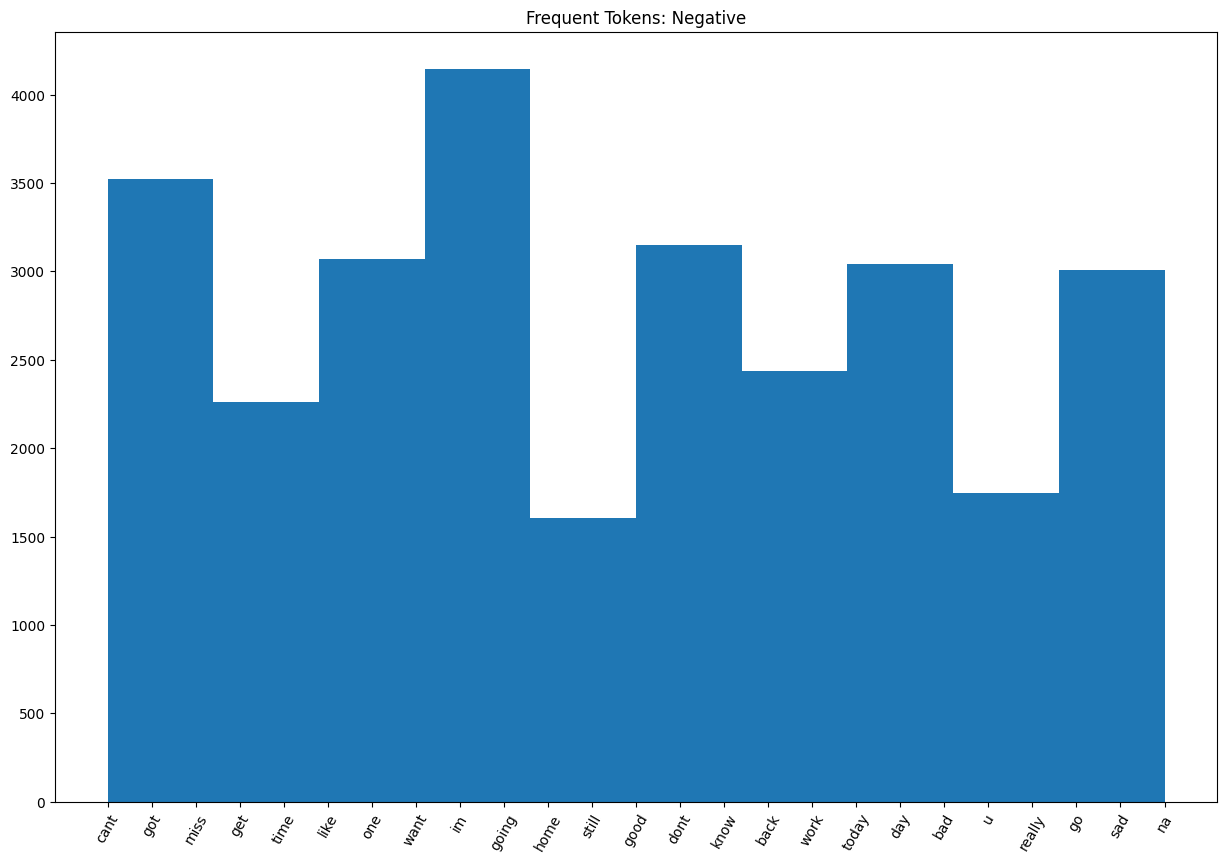

In [123]:
negative_tokens = word_tokenize(" ".join(df[df['sentiment']==0]["text"].values))
frequent_tokens_negative = identify_most_frequent(negative_tokens,25)

fig, ax = plt.subplots(nrows=1, figsize=(15,10))

ax.hist(frequent_tokens_negative)
ax.set_title("Frequent Tokens: Negative")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

Analyze tweet length distributions.

Text(0.5, 1.0, 'Tweet Length Distribution (words): Negative')

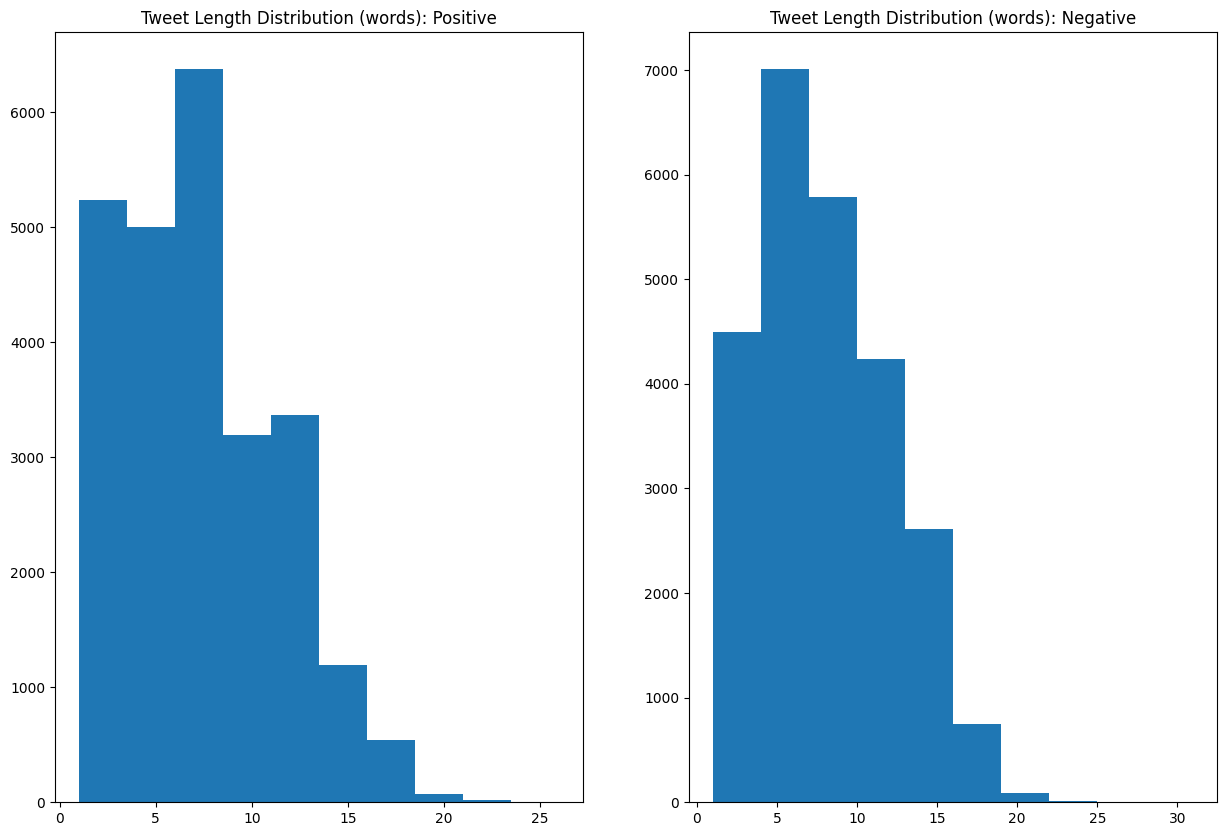

In [125]:
positive_lengths = [len(tweet.split(' ')) for tweet in df[df['sentiment']==4]["text"].values]
negative_lengths = [len(tweet.split(' ')) for tweet in df[df['sentiment']==0]["text"].values]

fig, ax = plt.subplots(ncols=2, figsize=(15,10))

ax[0].hist(positive_lengths)
ax[0].set_title("Tweet Length Distribution (words): Positive")

ax[1].hist(negative_lengths)
ax[1].set_title("Tweet Length Distribution (words): Negative")